In [1]:
import os
import pickle
import torch
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from abc import ABC, abstractmethod
from sklearn.neighbors import NearestNeighbors
from sentence_transformers import SentenceTransformer 
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
class BaseRecommender(ABC):
    def __init__(self, name):
        self.name = name
        self.train_df = None
        
    @abstractmethod
    def fit(self, train_df):
        """Treina o modelo com os dados de treino."""
        pass
    
    @abstractmethod
    def recommend(self, author_id, top_n=10):
        """Retorna uma lista de author_ids recomendados."""
        pass

In [3]:
class TopologyRecommender(BaseRecommender):
    def __init__(self):
        super().__init__("Topology (Graph Coauthor)")
        self.graph = defaultdict(set)
        self.popular_authors = []
        
    def fit(self, train_df):
        self.train_df = train_df
        print(f"[{self.name}] Construindo grafo...")
        
        # Construção do Grafo
        for _, group in train_df.groupby('work_id'):
            authors = group['author_id'].tolist()
            if len(authors) > 1:
                for u, v in itertools.permutations(authors, 2):
                    self.graph[u].add(v)
        
        # Cálculo de Popularidade (para fallback)
        popularity_counter = Counter()
        for author, neighbors in self.graph.items():
            popularity_counter[author] = len(neighbors)
        self.popular_authors = [auth for auth, _ in popularity_counter.most_common()]
        print(f"[{self.name}] Grafo construído com {len(self.graph)} autores.")

    def recommend(self, author_id, top_n=10):
        recommendations = []
        current_coauthors = self.graph.get(author_id, set())
        
        # Lógica de Amigos em Comum (2 hops)
        if author_id in self.graph:
            candidates = []
            for neighbor in current_coauthors:
                neighbors_of_neighbor = self.graph.get(neighbor, set())
                for candidate in neighbors_of_neighbor:
                    if candidate != author_id and candidate not in current_coauthors:
                        candidates.append(candidate)
            
            recommendations = [c[0] for c in Counter(candidates).most_common(top_n)]
        
        # Fallback: Populares
        if len(recommendations) < top_n:
            for pop in self.popular_authors:
                if pop != author_id and pop not in recommendations and pop not in current_coauthors:
                    recommendations.append(pop)
                    if len(recommendations) >= top_n:
                        break
                        
        return recommendations[:top_n]


In [ ]:
class InstitutionRecommender(BaseRecommender):
    def __init__(self):
        super().__init__("Institution Match")
        self.author_institutions = defaultdict(set)
        self.institution_authors = defaultdict(set)
        self.popular_authors = []
        
    def fit(self, train_df):
        self.train_df = train_df
        print(f"[{self.name}] Mapeando instituições...")
        
        # Itera sobre o DataFrame para preencher o mapa Autor <-> Instituição
        # Vamos tratar casos onde institution_ids pode ser string com '|' ou NaN
        for _, row in train_df.iterrows():
            auth_id = row['author_id']
            inst_raw = row.get('institution_ids')
            
            if pd.notna(inst_raw) and isinstance(inst_raw, str):
                # Separa por '|' e limpa espaços
                institutions = [i.strip() for i in inst_raw.split('|') if i.strip()]
                
                for inst in institutions:
                    self.author_institutions[auth_id].add(inst)
                    self.institution_authors[inst].add(auth_id)
                    
        # Calcular popularidade global (fallback)
        popularity_counter = Counter()
        for author, neighbors in self.graph.items():
            popularity_counter[author] = len(neighbors)
        self.popular_authors = [auth for auth, _ in popularity_counter.most_common()]
                    

    def recommend(self, author_id, top_n=10):
        # Se o autor não tem instituição conhecida no treino, retorna vazio
        if author_id not in self.author_institutions:
            return []
            
        my_institutions = self.author_institutions[author_id]
        candidates = []
        
        # Encontra todos os autores que compartilham pelo menos uma instituição
        for inst in my_institutions:
            candidates.extend(list(self.institution_authors[inst]))
            
        # Conta frequência (quem compartilha mais instituições aparece primeiro)
        # Filtra o próprio autor
        candidates = [c for c in candidates if c != author_id]
        ranked_candidates = [c[0] for c in Counter(candidates).most_common(top_n)]
        
        # Fallback: Populares
        if len(ranked_candidates) < top_n:
            for pop in self.popular_authors:
                if pop != author_id and pop not in ranked_candidates:
                    ranked_candidates.append(pop)
                    if len(ranked_candidates) >= top_n:
                        break
        
        return ranked_candidates

In [5]:
class HybridRecommender(BaseRecommender):
    def __init__(self):
        super().__init__("Hybrid (Inst + Topology)")
        self.graph = defaultdict(set)
        self.author_institutions = defaultdict(set)
        self.institution_authors = defaultdict(set)
        self.popular_authors = []

    def fit(self, train_df):
        print(f"[{self.name}] Treinando modelo híbrido...")
        
        # 1. Construir Grafo de Coautoria (Topologia)
        for _, group in train_df.groupby('work_id'):
            authors = group['author_id'].tolist()
            if len(authors) > 1:
                for u, v in itertools.permutations(authors, 2):
                    self.graph[u].add(v)
        
        # 2. Construir Mapa de Instituições
        for _, row in train_df.iterrows():
            auth_id = row['author_id']
            inst_raw = row.get('institution_ids')
            if pd.notna(inst_raw) and isinstance(inst_raw, str):
                institutions = [i.strip() for i in inst_raw.split('|') if i.strip()]
                for inst in institutions:
                    self.author_institutions[auth_id].add(inst)
                    self.institution_authors[inst].add(auth_id)
        
        # 3. Calcular popularidade global (fallback)
        popularity_counter = Counter()
        for author, neighbors in self.graph.items():
            popularity_counter[author] = len(neighbors)
        self.popular_authors = [auth for auth, _ in popularity_counter.most_common()]
        
        print(f"[{self.name}] Treino concluído.")

    def recommend(self, author_id, top_n=10):
        # Passo 0: Pega coautores atuais para remover das recomendações
        current_coauthors = self.graph.get(author_id, set())
        
        # Passo 1: FILTRO - Candidatos devem ser da mesma instituição
        my_institutions = self.author_institutions.get(author_id, set())
        candidates_set = set()
        
        for inst in my_institutions:
            candidates_set.update(self.institution_authors[inst])
            
        # Remove o próprio autor e quem já é coautor
        candidates_set.discard(author_id)
        candidates_set -= current_coauthors
        
        candidates_list = list(candidates_set)
        
        # Se não houver candidatos na mesma instituição, podemos retornar vazio ou fallback global
        if not candidates_list:
            # Opção: Retornar fallback global se quiser preencher a lista
            # return self._get_fallback(current_coauthors, author_id, top_n)
            return []

        # Passo 2: RANKING - Aplicar Topologia (Common Neighbors) nesses candidatos
        candidate_scores = []
        
        my_neighbors = self.graph.get(author_id, set())
        
        for cand in candidates_list:
            cand_neighbors = self.graph.get(cand, set())
            
            # Métrica 1: Número de vizinhos em comum (Friends of Friends)
            common_neighbors = len(my_neighbors.intersection(cand_neighbors))
            
            # Métrica 2 (Desempate): Popularidade do candidato (grau no grafo)
            popularity = len(cand_neighbors)
            
            candidate_scores.append((cand, common_neighbors, popularity))
        
        # Ordena: 1º por vizinhos em comum (decrescente), 2º por popularidade (decrescente)
        candidate_scores.sort(key=lambda x: (x[1], x[2]), reverse=True)
        
        recommendations = [x[0] for x in candidate_scores[:top_n]]
        
        return recommendations

    def _get_fallback(self, current_coauthors, author_id, top_n):
        recs = []
        for pop in self.popular_authors:
            if pop != author_id and pop not in current_coauthors:
                recs.append(pop)
                if len(recs) >= top_n:
                    break
        return recs

In [6]:
def evaluate_models(models, test_ground_truth, train_graph_check, K_values=[5, 10]):
    results = {}
    
    for model in models:
        print(f"\nAvaliando modelo: {model.name}...")
        model_metrics = {k: {'precision': [], 'recall': []} for k in K_values}
        
        for author_id, actual_new_coauthors in test_ground_truth.items():
            max_k = max(K_values)
            recs = model.recommend(author_id, top_n=max_k)
            
            past_coauthors = train_graph_check.get(author_id, set())
            recs = [r for r in recs if r not in past_coauthors]
            
            for k in K_values:
                top_k_recs = recs[:k]
                hits = len(set(top_k_recs) & actual_new_coauthors)
                
                p = hits / k if k > 0 else 0
                r = hits / len(actual_new_coauthors) if len(actual_new_coauthors) > 0 else 0
                
                model_metrics[k]['precision'].append(p)
                model_metrics[k]['recall'].append(r)
        
        # Média final
        results[model.name] = {}
        for k in K_values:
            avg_p = np.mean(model_metrics[k]['precision'])
            avg_r = np.mean(model_metrics[k]['recall'])
            f1 = 2 * (avg_p * avg_r) / (avg_p + avg_r) if (avg_p + avg_r) > 0 else 0
            
            results[model.name][k] = {'P': avg_p, 'R': avg_r, 'F1': f1}
            print(f"  K={k}: Precision={avg_p:.4f}, Recall={avg_r:.4f}, F1={f1:.4f}")
            
    return results

In [7]:
def plot_model_comparison(results, figsize=(15, 5)):
    model_names = list(results.keys())
    k_values = sorted(list(results[model_names[0]].keys()))
    
    # Preparar dados para cada métrica
    metrics_data = {
        'Precision': {model: [results[model][k]['P'] for k in k_values] for model in model_names},
        'Recall': {model: [results[model][k]['R'] for k in k_values] for model in model_names},
        'F1-Score': {model: [results[model][k]['F1'] for k in k_values] for model in model_names}
    }
    
    # Criar figura com 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle('Comparação de Modelos de Link Prediction', fontsize=16, fontweight='bold')
    
    # Cores e estilos para cada modelo
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    markers = ['o', 's', '^', 'D', 'v']
    
    # Plotar cada métrica
    for idx, (metric_name, data) in enumerate(metrics_data.items()):
        ax = axes[idx]
        
        for i, model in enumerate(model_names):
            ax.plot(
                k_values, 
                data[model], 
                marker=markers[i % len(markers)],
                label=model,
                color=colors[i % len(colors)],
                linewidth=2,
                markersize=8
            )
        
        ax.set_xlabel('K (Top-K)', fontsize=11)
        ax.set_ylabel(metric_name, fontsize=11)
        ax.set_title(f'{metric_name} por K', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(fontsize=9)
        ax.set_xticks(k_values)
        
    plt.tight_layout()
    plt.show()
    
    return fig

In [8]:
database_path = 'database_50k'
authors_df = pd.read_csv(f'{database_path}/authorships.csv')
works_df = pd.read_csv(f'{database_path}/works.csv')

merged_df = authors_df.merge(
    works_df[['id', 'publication_date', 'title', 'abstract', 'language']], 
    left_on='work_id', right_on='id'
)
merged_df['publication_date'] = pd.to_datetime(merged_df['publication_date'], errors='coerce')
merged_df = merged_df.dropna(subset=['publication_date', 'author_id', 'title', 'abstract', 'language', 'institution_ids']).drop(columns=['id'])
merged_df = merged_df[merged_df['language'] == 'en']

unique_works = merged_df[['work_id', 'publication_date']].drop_duplicates().sort_values('publication_date')
split_idx = int(len(unique_works) * 0.8)

train_work_ids = set(unique_works.iloc[:split_idx]['work_id'])
test_work_ids = set(unique_works.iloc[split_idx:]['work_id'])

train_df = merged_df[merged_df['work_id'].isin(train_work_ids)].copy()
test_df = merged_df[merged_df['work_id'].isin(test_work_ids)].copy()

def build_graph(df):
    graph = defaultdict(set)
    for _, group in df.groupby('work_id'):
        authors = group['author_id'].tolist()
        
        if len(authors) > 1:
            for u, v in itertools.permutations(authors, 2):
                graph[u].add(v)

    return graph

train_graph = build_graph(train_df)
test_graph_raw = build_graph(test_df)

test_ground_truth = defaultdict(set)

for author, coauthors in test_graph_raw.items():
    # Pega quem o autor colaborou no futuro
    future_coauthors = coauthors
    
    # Remove quem ele já conhecia no passado (não é predição nova)
    past_coauthors = train_graph.get(author, set())
    new_links = future_coauthors - past_coauthors
    
    if new_links:
        test_ground_truth[author] = new_links

C:\Users\BSBCo\AppData\Local\Temp\ipykernel_33304\171367733.py:3: DtypeWarning: Columns (0: is_retracted) have mixed types. Specify dtype option on import or set low_memory=False.
  works_df = pd.read_csv(f'{database_path}/works.csv')


[Topology (Graph Coauthor)] Construindo grafo...
[Topology (Graph Coauthor)] Grafo construído com 17601 autores.
[Institution Match] Mapeando instituições...
[Institution Match] Mapeamento concluído.
[Hybrid (Inst + Topology)] Treinando modelo híbrido...
[Hybrid (Inst + Topology)] Treino concluído.

Avaliando modelo: Topology (Graph Coauthor)...
  K=5: Precision=0.0150, Recall=0.0141, F1=0.0145
  K=10: Precision=0.0140, Recall=0.0244, F1=0.0178
  K=20: Precision=0.0123, Recall=0.0424, F1=0.0190
  K=50: Precision=0.0078, Recall=0.0622, F1=0.0139

Avaliando modelo: Institution Match...
  K=5: Precision=0.0043, Recall=0.0032, F1=0.0037
  K=10: Precision=0.0033, Recall=0.0053, F1=0.0040
  K=20: Precision=0.0024, Recall=0.0080, F1=0.0037
  K=50: Precision=0.0016, Recall=0.0140, F1=0.0028

Avaliando modelo: Hybrid (Inst + Topology)...
  K=5: Precision=0.0101, Recall=0.0095, F1=0.0098
  K=10: Precision=0.0071, Recall=0.0131, F1=0.0092
  K=20: Precision=0.0046, Recall=0.0160, F1=0.0071
  K=50:

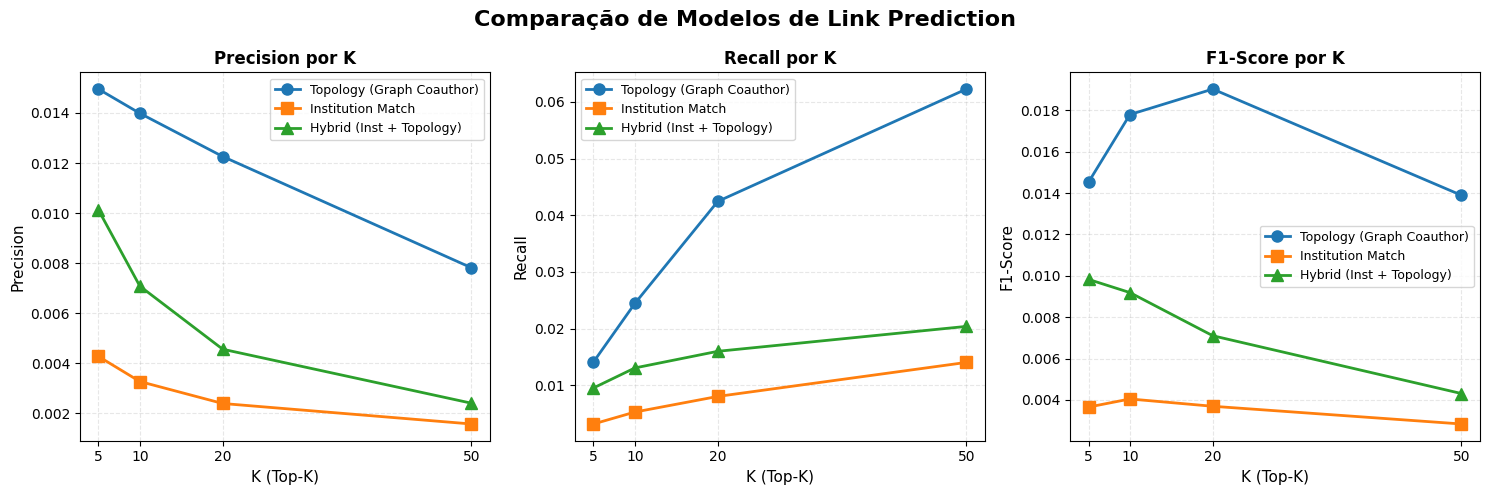

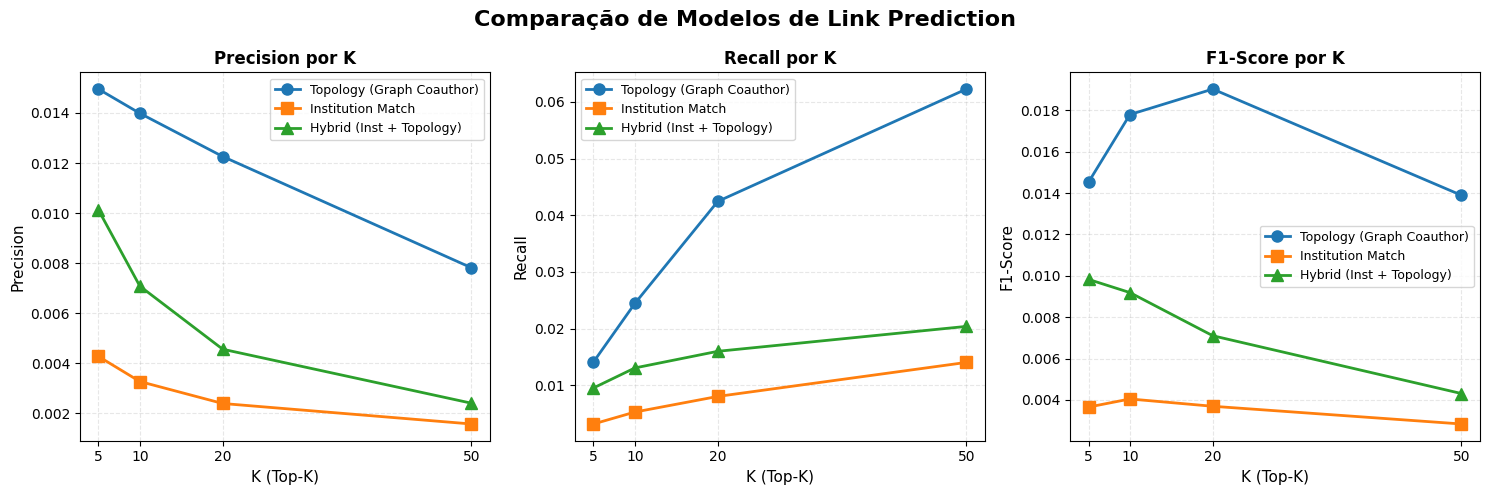

In [9]:
topo_model = TopologyRecommender()
inst_model = InstitutionRecommender()
hybrid_model = HybridRecommender()

models = [topo_model, inst_model, hybrid_model]

for model in models:
    model.fit(train_df) 
    
metrics = evaluate_models(models, test_ground_truth, train_graph, K_values=[5, 10, 20, 50])
plot_model_comparison(metrics)